In [32]:
import numpy as np
import pandas as pd
import seaborn as sns
import dynamo
import dynamo as dyn
from dynamo.preprocessing import Preprocessor
import pearson_residual_normalization_recipe
from benchmark_utils import *

adata_origin = dyn.sample_data.zebrafish()

|-----> Downloading data to ./data/zebrafish.h5ad


## Convert and Output Data for R Seurat inputs

In [2]:
import scipy
import scipy.io
def write_R_input_data():
    dyn_adata = dyn.sample_data.zebrafish()
    print("original data shape:", dyn_adata.shape)
    dyn.preprocessing.convert_layers2csr(dyn_adata)
    dyn.preprocessing.unique_var_obs_adata(dyn_adata)
    dyn.preprocessing.filter_cells_by_outliers(dyn_adata)
    scipy.io.mmwrite("counts.mtx", dyn_adata.X)
    scipy.io.mmwrite("spliced.mtx", dyn_adata.layers["spliced"])
    scipy.io.mmwrite("unspliced.mtx", dyn_adata.layers["unspliced"])
    print(dyn_adata)
    pd.Series(dyn_adata.obs_names).to_csv("./data/cell_names.csv")
    pd.Series(dyn_adata.var_names).to_csv("./data/var_names.csv")
write_R_input_data()


Read R results

In [51]:
seurat_X_pca = pd.read_csv("./R-seurat-test/X_pca.csv")
# seurat_features = pd.read_csv("./R-seurat-test/features_attributes.csv")
seurat_features = pd.read_csv("./R-seurat-test/glmGamPoi/features_attributes.csv")
seurat_residual_variance = seurat_features["residual_variance"]
seurat_residual_mean = seurat_features["residual_mean"]




In [4]:
print(seurat_features.shape)
seurat_features[:2]

(14561, 13)


,Unnamed: 0,detection_rate,gmean,variance,residual_mean,residual_variance,theta,(Intercept),log_umi,genes_log_gmean_step1,step1_theta,step1_(Intercept),step1_log_umi
0,tmsb4x,0.996880,24.044729,646.209685,1.473782,7.568099,8.202726,-5.850218,2.616656,True,3.043571,-0.868649,1.265214
1,rpl8,0.970722,9.071542,268.856675,0.357199,1.334362,8.499595,-7.591408,2.904164,True,9.536713,-7.594099,2.953750


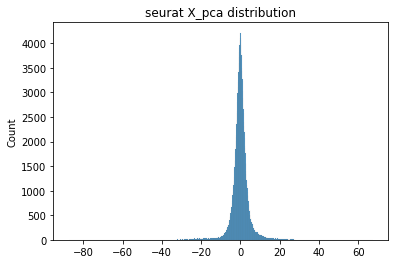

In [5]:
X_pca_arr = seurat_X_pca.to_numpy().flatten()
sns.histplot(X_pca_arr).set_title("seurat X_pca distribution")
plt.show()
# sns.histplot(seurat_residual_mean.to_numpy().flatten()).set_title("seurat residual mean")
# plt.show()
# sns.histplot(seurat_residual_variance.to_numpy().flatten()).set_title("seurat residual variance")
# plt.show()

## Obtain seurat adata and set correspondin fields for next comparison steps

In [6]:
seurat_adata = dyn.sample_data.zebrafish()
dyn.preprocessing.unique_var_obs_adata(seurat_adata)
dyn.preprocessing.filter_cells_by_outliers(seurat_adata)
print(seurat_X_pca.shape)
print(seurat_adata.shape)
print(set(seurat_X_pca.index) - set(seurat_adata.obs_names))
print(set(seurat_adata.obs_names) - set(seurat_X_pca.index))


|-----> Downloading data to ./data/zebrafish.h5ad
|-----------> filtering cells by layer:X
|-----------> filtering cells by layer:spliced
|-----------> filtering cells by layer:unspliced
|-----> skip filtering by layer:protein as it is not in adata.
|-----> <insert> pass_basic_filter to obs in AnnData Object.
|-----------> inplace subsetting adata by filtered cells


(4167, 50)
(4167, 16940)
set()
set()


### Reorder seurat_X_pca index in adata obs_name order and set to X_pca

In [7]:

seurat_adata.obsm["X_pca"] = seurat_X_pca.loc[seurat_adata.obs_names, :].to_numpy()


## sample preprocessor code  
Here we load the preprocessed data
```
from SCTransform import SCTransform
dyn_adata_preprocessor = dyn.sample_data.zebrafish()
preprocessor = Preprocessor()
preprocessor.config_monocle_recipe(dyn_adata_preprocessor)
preprocessor.normalize_by_cells = None
# preprocessor.select_genes_function = pearson_residual_normalization_recipe.select_genes_by_pearson_residual
# preprocessor.normalize_selected_genes_function = pearson_residual_normalization_recipe.normalize_layers_pearson_residuals
preprocessor.filter_cells_by_outliers(dyn_adata_preprocessor, keep_filtered=False)
preprocessor.filter_genes_by_outliers(dyn_adata_preprocessor, inplace=True)
SCTransform(dyn_adata_preprocessor, inplace=True)
preprocessor.use_log1p = False
preprocessor.pca(dyn_adata, n_pca_components=50)
```

In [8]:
dyn_adata_preprocessor = dyn.read_h5ad(
    "./data/zebrafish_sctransform_preprocessor.h5ad")


In [9]:
dyn_adata_preprocessor.var["genes_step1_sct"].sum()


1912.0

In [10]:
print(seurat_X_pca.shape)
print(dyn_adata_preprocessor.shape)

(4167, 50)
(4167, 16940)


### compare the shape of X_pca

In [11]:
print(dyn_adata_preprocessor.obsm["X_pca"].shape)
seurat_adata.obsm["X_pca"].shape


(4167, 50)


(4167, 50)

In [66]:
dyn_adata_preprocessor.var.columns

Index(['pass_basic_filter', 'Intercept_sct', 'log_umi_sct', 'theta_sct',
       'Intercept_step1_sct', 'log_umi_step1_sct', 'dispersion_step1_sct',
       'genes_step1_sct', 'log10_gmean_sct', 'use_for_pca'],
      dtype='object')

<AxesSubplot:>

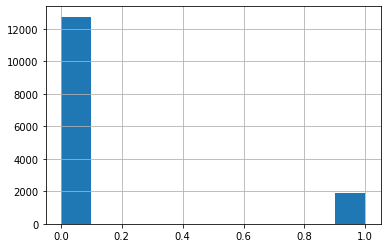

In [70]:
dyn_adata_preprocessor.var["genes_step1_sct"].sum()

### distribution comparisons

<AxesSubplot:>

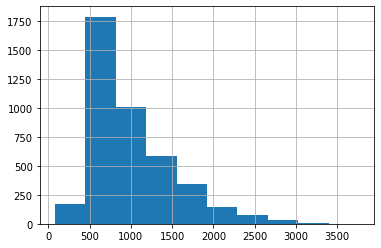

In [71]:
dyn_adata_preprocessor.obs["gene_sct"].hist()

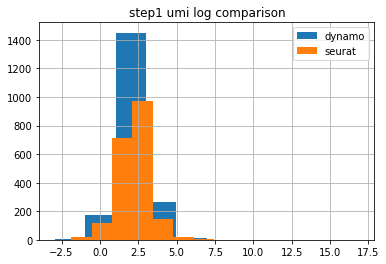

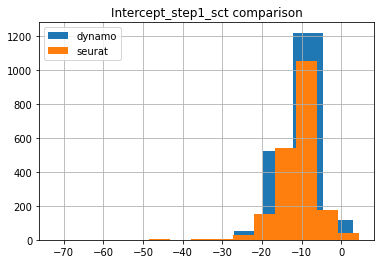

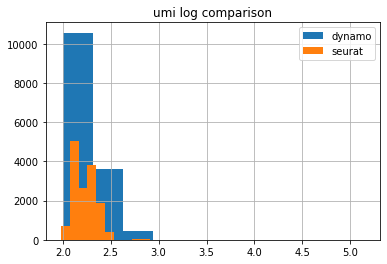

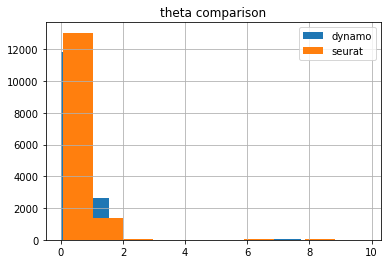

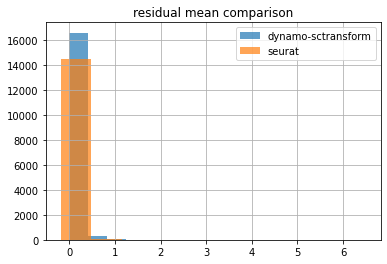

<Figure size 432x288 with 0 Axes>

In [65]:
dyn_adata_preprocessor.var["log_umi_step1_sct"].hist(label="dynamo")
seurat_features["step1_log_umi"].hist(label="seurat")
plt.title("step1 umi log comparison")
plt.legend()
plt.show()
plt.clf()

dyn_adata_preprocessor.var["Intercept_step1_sct"].hist(label="dynamo")
seurat_features["step1_(Intercept)"].hist(label="seurat")
plt.title("Intercept_step1_sct comparison")
plt.legend()
plt.show()
plt.clf()


dyn_adata_preprocessor.var["log_umi_sct"].hist(label="dynamo")
seurat_features["log_umi"].hist(label="seurat")
plt.title("umi log comparison")
plt.legend()
plt.show()
plt.clf()

dyn_adata_preprocessor.var["theta_sct"].hist(label="dynamo")
seurat_features["theta"].hist(label="seurat")
plt.title("theta comparison")
plt.legend()
plt.show()
plt.clf()

pd.Series(np.array(dyn_adata_preprocessor.X.mean(0)).flatten()).hist(label="dynamo-sctransform", alpha=0.7) # , figsize=(20,20))
# pd.Series(np.array(adata_origin.X.mean(0)).flatten()).hist(label="dynamo-origin", alpha=0.7)
seurat_features["residual_mean"].hist(label="seurat", alpha=0.7)
plt.title("residual mean comparison")
plt.legend()
plt.show()
plt.clf()


In [63]:
seurat_features["step1_log_umi"]

0        1.265214
1        2.953750
2        3.098540
3        2.948107
4        3.065184
           ...   
14556         NaN
14557         NaN
14558         NaN
14559    3.530216
14560         NaN
Name: step1_log_umi, Length: 14561, dtype: float64

Text(0.5, 1.0, 'X_pca')

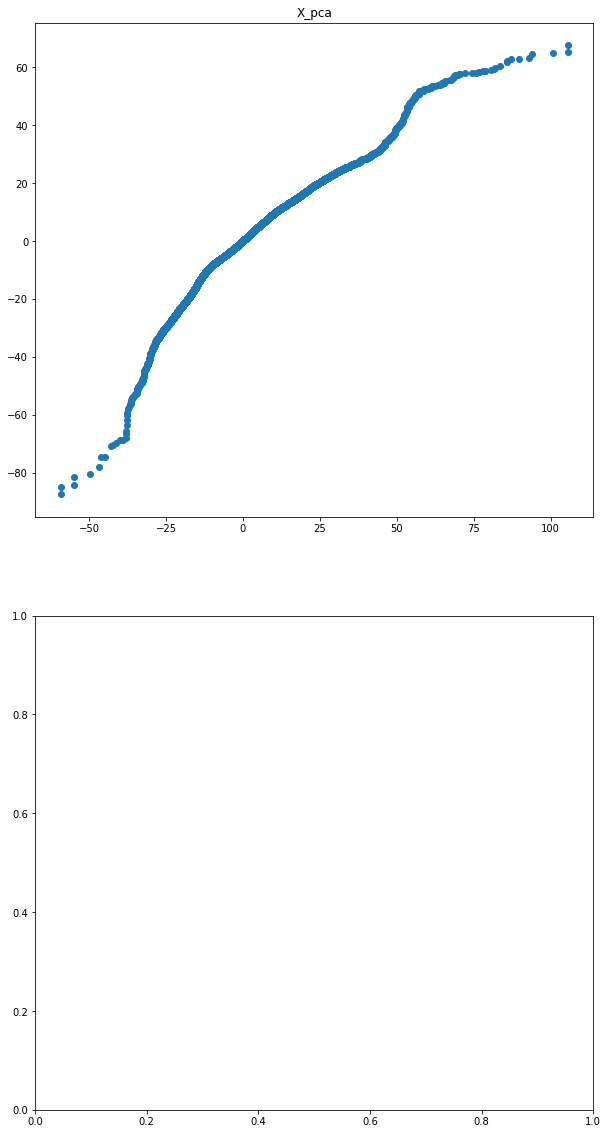

In [59]:
fig, axes = plt.subplots(2, figsize=(10, 20))
key = "X_pca"
use_for_pca = list(
    set(dyn_adata_preprocessor.var_names[dyn_adata_preprocessor.var["use_for_pca"]]))
axes[0].scatter(np.sort(dyn_adata_preprocessor.obsm[key].flatten()),
                np.sort(seurat_adata[dyn_adata_preprocessor.obs_names, :].obsm[key].flatten()))  # , title="X_pca comparison")
axes[0].set_title(key)


<Figure size 600x400 with 0 Axes>

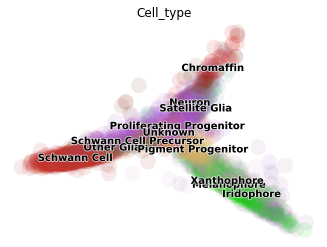

<Figure size 600x400 with 0 Axes>

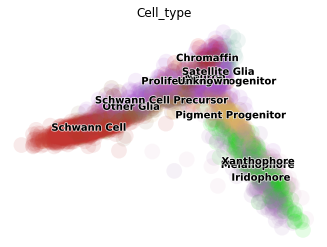

In [60]:

dyn.pl.scatters(dyn_adata_preprocessor, basis="pca", color="Cell_type")
dyn.pl.scatters(seurat_adata, basis="pca", color="Cell_type")


|-----> retrive data for non-linear dimension reduction...
|-----? adata already have basis umap. dimension reduction umap will be skipped! 
set enforce=True to re-performing dimension reduction.
|-----> [dimension_reduction projection] in progress: 100.0000%
|-----> [dimension_reduction projection] finished [0.0020s]


<Figure size 1000x1000 with 0 Axes>

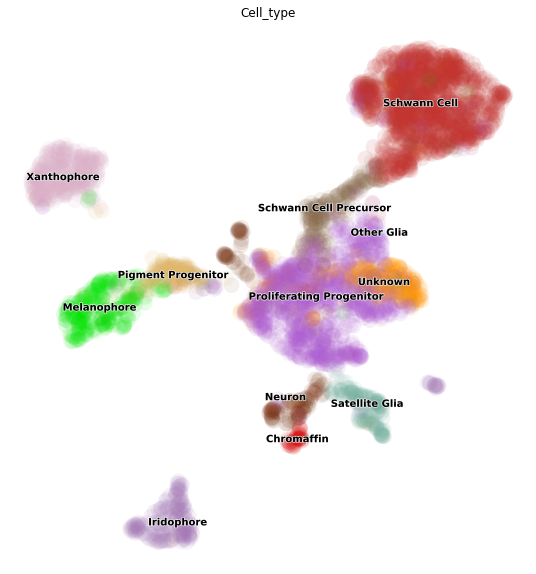

In [54]:

dyn.tl.reduceDimension(seurat_adata, basis="pca")
dyn.pl.umap(seurat_adata, color="Cell_type", figsize=(10, 10))


|-----> retrive data for non-linear dimension reduction...
|-----? adata already have basis umap. dimension reduction umap will be skipped! 
set enforce=True to re-performing dimension reduction.
|-----> [dimension_reduction projection] in progress: 100.0000%
|-----> [dimension_reduction projection] finished [0.0010s]


<Figure size 1000x1000 with 0 Axes>

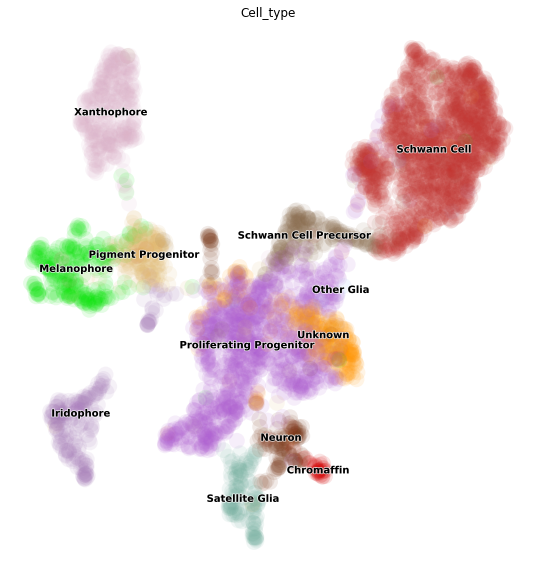

In [55]:
dyn.tl.reduceDimension(dyn_adata_preprocessor, basis="pca")
dyn.pl.umap(dyn_adata_preprocessor, color="Cell_type", figsize=(10, 10))
